In [7]:
# Code gotten from: https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/deep-learning/16.attention-is-all-you-need.ipynb
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [24]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [76]:
from google.colab import drive
import numpy as np
from numpy import genfromtxt


#shuffler
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


X_Dat=[]


drive.mount('/content/drive')


for i in range(100): 
  daty = genfromtxt("/content/drive/My Drive/Colab Notebooks/CNN_LSTM_COVID/Input/dat"+str(i+1)+".csv", delimiter=',')# My reference Image
  X_Dat.append(daty[:,:])

X_datnew=np.asarray(X_Dat)

X=X_datnew


##################################################################################

Y=np.zeros((100,9))

for i in range(100):
  my_data = genfromtxt("/content/drive/My Drive/Colab Notebooks/CNN_LSTM_COVID/Labels/lab"+str(i+1)+".csv", delimiter=',')
  Y[i,:]=my_data
    
    
###################################################################################

#Random Shuffling
X,Y=unison_shuffled_copies(X, Y)

# Split the dataset
split_train = int(len(X)*0.7)
split_valid = int(len(X)*0.9)

# Train

X_train = X[:split_train, :]; y_train=Y[:split_train, :]

# Valid

X_valid = X[split_train:split_valid,:]; y_valid=Y[split_train:split_valid,:]

# Test

X_test = X[split_valid:,:]; y_test=Y[split_valid:,:]

   
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


# X_train*= (1.0/X_train.max())
# X_train = X_train.astype('float64')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(70, 201, 9) (70, 9)
(20, 201, 9) (20, 9)
(10, 201, 9) (10, 9)


In [90]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate,size_1,size_2, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.placeholder(tf.float32, (None,size_1, size_2))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = 0.8)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [134]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 100
dropout_rate = 0.8
learning_rate = 0.001

In [135]:
def predictor():
    tf.compat.v1.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, 201,9, 9)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    # date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, 70):
            index = k
            batch_x=X_train[index:index+1,:,:]
            batch_y=np.expand_dims(y_train[index,:], axis = 0)
            
           
           
            # batch_x = np.expand_dims(
            #     df_train.iloc[k : index, :].values, axis = 0
            # )
            # batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
  

    output_predict = np.zeros((y_test.shape[0],y_test.shape[1]))


    for k in range(0, 10):
        index=k
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X:X_test[index:index+1,:,:]
            },
        )
        
        output_predict[k,:] = out_logits[-1]
        

    
    
    return total_acc,total_loss,output_predict

In [136]:
results = []
for i in range(1):
    print('simulation %d'%(i + 1))
    acc,loss,out=predictor()
    results.append(acc)

simulation 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense`

Text(0.5, 1.0, 'Trainingnloss')

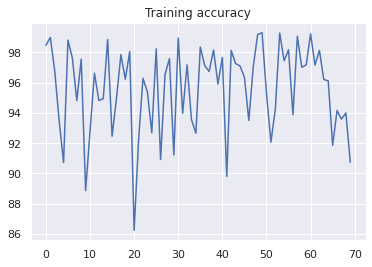

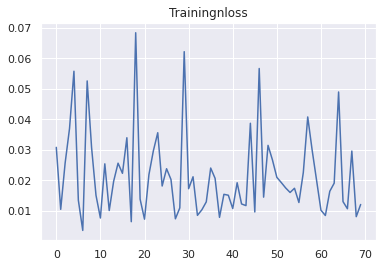

In [137]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss)

plt.title('Trainingnloss')

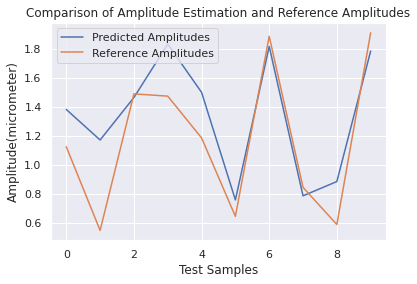

In [138]:
plt.plot(out[:,0],label="Predicted Amplitudes")
plt.plot(y_test[:,0],label="Reference Amplitudes")
plt.legend(loc="upper left")
plt.xlabel('Test Samples')
plt.ylabel('Amplitude(micrometer)')
plt.title('Comparison of Amplitude Estimation and Reference Amplitudes')
plt.show()

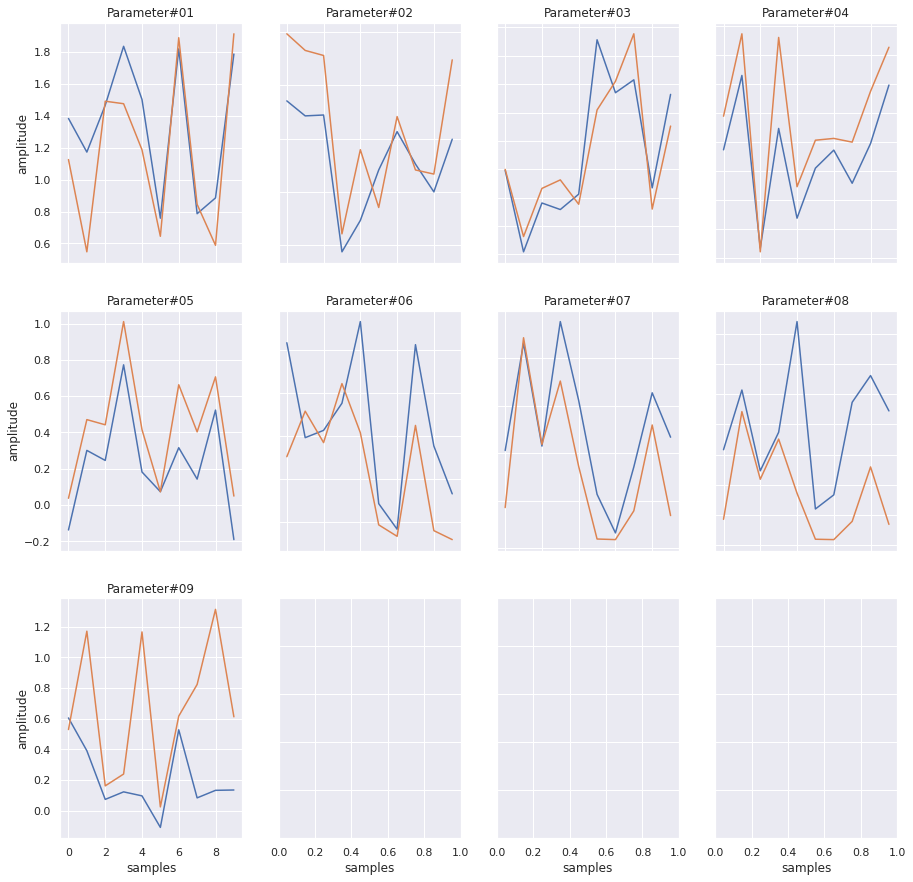

In [139]:
y_predictim=out

fig, axs = plt.subplots(3, 4,figsize=(15,15))

axs[0, 0].plot(y_predictim[:,0],label="Predicted Amplitudes")
axs[0,0].plot(y_test[:,0],label="Reference Amplitudes")
axs[0, 0].set_title('Parameter#01')
axs[0, 1].plot(y_predictim[:,1],label="Predicted Amplitudes")
axs[0,1].plot(y_test[:,1],label="Reference Amplitudes")
axs[0, 1].set_title('Parameter#02')
axs[0, 2].plot(y_predictim[:,2],label="Predicted Amplitudes")
axs[0,2].plot(y_test[:,2],label="Reference Amplitudes")
axs[0,2].set_title('Parameter#03')
axs[0, 3].plot(y_predictim[:,3],label="Predicted Amplitudes")
axs[0,3].plot(y_test[:,3],label="Reference Amplitudes")
axs[0,3].set_title('Parameter#04')
axs[1, 0].plot(y_predictim[:,4],label="Predicted Amplitudes")
axs[1,0].plot(y_test[:,4],label="Reference Amplitudes")
axs[1, 0].set_title('Parameter#05')
axs[1, 1].plot(y_predictim[:,5],label="Predicted Amplitudes")
axs[1,1].plot(y_test[:,5],label="Reference Amplitudes")
axs[1, 1].set_title('Parameter#06')
axs[1, 2].plot(y_predictim[:,6],label="Predicted Amplitudes")
axs[1,2].plot(y_test[:,6],label="Reference Amplitudes")
axs[1, 2].set_title('Parameter#07')
axs[1, 3].plot(y_predictim[:,7],label="Predicted Amplitudes")
axs[1,3].plot(y_test[:,6],label="Reference Amplitudes")
axs[1,3].set_title('Parameter#08')
axs[2, 0].plot(y_predictim[:,8],label="Predicted Amplitudes")
axs[2,0].plot(y_test[:,7],label="Reference Amplitudes")
axs[2,0].set_title('Parameter#09')


for ax in axs.flat:
    ax.set(xlabel='samples', ylabel='amplitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()